<a href="https://colab.research.google.com/github/ncy906302/Django-Nginx-uwsgi-setting/blob/master/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  33.5M      0  0:00:22  0:00:22 --:--:-- 35.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  11.5M      0  0:00:01  0:00:01 --:--:-- 11.5M


In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


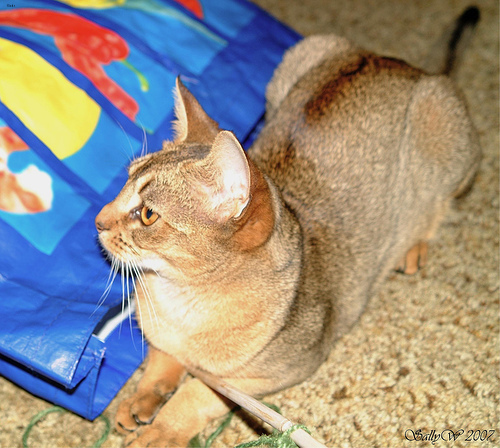

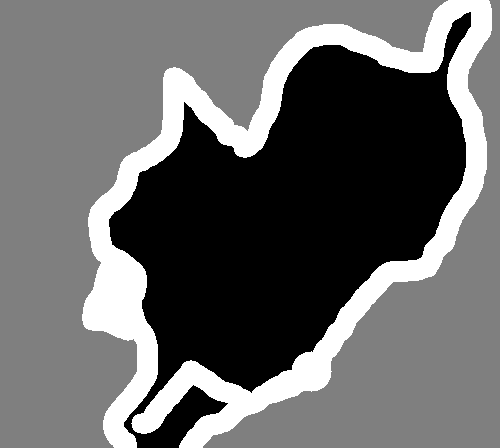

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps


display(Image(filename=input_img_paths[9]))


img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(batch_size=1,shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D()(x)

        # Project residual
        residual = layers.UpSampling2D()(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 160, 160, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 80, 80, 32)      896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 80, 80, 32)      128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (1, 80, 80, 32)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 90s 262ms/step - loss: 1.5952 - val_loss: 2.0769
Epoch 2/15
199/199 [==============================] - 51s 256ms/step - loss: 0.5170 - val_loss: 2.0540
Epoch 3/15
199/199 [==============================] - 51s 256ms/step - loss: 0.4315 - val_loss: 0.4528
Epoch 4/15
199/199 [==============================] - 52s 259ms/step - loss: 0.3785 - val_loss: 0.4289
Epoch 5/15
199/199 [==============================] - 51s 256ms/step - loss: 0.3433 - val_loss: 0.3873
Epoch 6/15
199/199 [==============================] - 51s 256ms/step - loss: 0.3105 - val_loss: 0.3693
Epoch 7/15
199/199 [==============================] - 51s 254ms/step - loss: 0.2887 - val_loss: 0.3700
Epoch 8/15
199/199 [==============================] - 51s 254ms/step - loss: 0.2626 - val_loss: 0.3887
Epoch 9/15
199/199 [==============================] - 51s 253ms/step - loss: 0.2467 - val_loss: 0.4332
Epoch 10/15
199/199 [==============================] - 51s 257ms/step - l

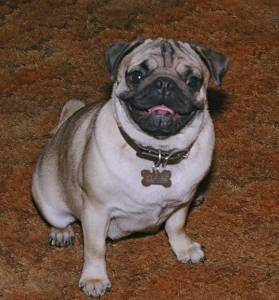

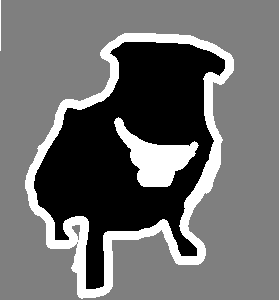

(160, 160)
(160, 160, 1)


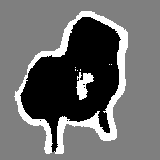

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    print(mask.shape)
    mask = np.expand_dims(mask, axis=-1)
    print(mask.shape)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [65]:
!wget https://img04.shop-pro.jp/PA01014/125/slideshow/slideshow_img_11284d.JPG?cmsp_timestamp=20200602215950 -O dog.jpg


--2021-03-23 06:05:32--  https://img04.shop-pro.jp/PA01014/125/slideshow/slideshow_img_11284d.JPG?cmsp_timestamp=20200602215950
Resolving img04.shop-pro.jp (img04.shop-pro.jp)... 99.84.214.103, 99.84.214.101, 99.84.214.110, ...
Connecting to img04.shop-pro.jp (img04.shop-pro.jp)|99.84.214.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2305478 (2.2M) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]   2.20M  --.-KB/s    in 0.03s   

2021-03-23 06:05:32 (70.0 MB/s) - ‘dog.jpg’ saved [2305478/2305478]



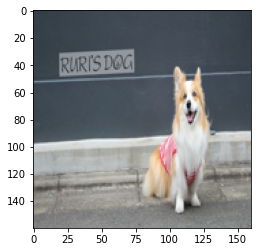

In [66]:
import matplotlib.pyplot as plt

from PIL import Image

img = np.array(Image.open('dog.jpg').resize((160, 160)))
plt.imshow(img)
plt.show()
img = np.array(img).astype(np.float32)

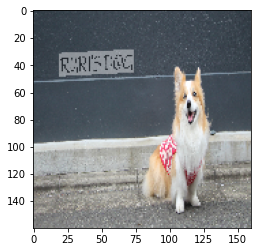

(160, 160)
(160, 160)


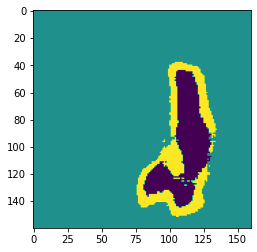

In [67]:
a = load_img('dog.jpg',target_size=(160,160,3))
# new_img = np.array(a).astype(np.float32)
# new_img.resize([160,160,3])
# new_img = np.array([new_img])
# new_img.shape
plt.imshow(a)
plt.show()
img = np.array(a).astype(np.float32)


# pred=model.predict(np.array([val_gen[0][0][0]]))
pred=model.predict(np.array([img]))
mask = np.argmax(pred, axis=-1)
mask = np.squeeze(mask,axis=0)
print(mask.shape)
# mask = np.expand_dims(mask, axis=-1)
print(mask.shape)
plt.imshow(mask)
plt.show()
# img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
# display(img)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzhpuoovj/assets


INFO:tensorflow:Assets written to: /tmp/tmpzhpuoovj/assets


8234096